<a href="https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/A_Gentle_Introduction_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Gentle Introduction to PyTorch

**Author:** [Elvis Saravia](https://twitter.com/omarsar0)

**Modified:** [David Macêdo](https://twitter.com/david_macedo)

---


## Getting Started


We need to import a few modules which will be useful to obtain the necessary functions that will help us to build our deep learning model. The main ones are `torch` and `torchvision`. They contain the majority of the functions that you need to get started with PyTorch. However, as this is a deep learning tutorial we will need `torch.nn`, `torch.nn.functional` and `torchvision.transforms` which all contain utility functions to build our model. We probably won't use all the modules listed below but they are the typical modules you will be importing when starting your deep learning projects.  

In [1]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## for printing image
import matplotlib.pyplot as plt
import numpy as np

Below we check for the PyTorch version just to make sure that you are using the proper version.

In [2]:
## print out the pytorch version used
print(torch.__version__)

1.7.0+cu101


## Loading the Data
Let's get right into it! As with any machine learning project, you need to load your dataset. We are using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which is the Hello World of datasets in the machine learning world. 

The data consists of number images that are of size `28 X 28`. We will discuss the images shortly, but our plan is to load data into batches of size `32`, similar to the figure below.


![alt text](https://drive.google.com/uc?export=view&id=19AC_WpscyXkrK_o4PaFFGpt_jG0aJm_f)


Here are the complete steps we are performing when importing our data:
- We will import and tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders, which makes it easy to efficiently feed data in batches to deep learning models. We will get to the topic of batches in a bit but for now just think of them as subsets of your data. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. 

In [3]:
## parameter denoting the batch size
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's inspect what the trainset and testset objects contain. 

In [4]:
## print the trainset and testset
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


This is a beginner's tutorial so I will break down things a bit here:
- `BATCH_SIZE` is a parameter that denotes the batch size we will use for our model
- `transform` holds code for whatever transformations you will apply to your data. I will show you an example below to demonstrate exactly what it does to shed more light into its use
- `trainset` and `testset` contain the actual dataset object. Notice I use `train=True` to specify that this corresponds to the training dataset, and I use `train=False` to specify that this is the remainder of the dataset which we call the testset. From the portion I printed above you can see that the split of the data was 85% (60000) / 15% (10000), corresponding to the portions of samples for training set and testing set, respectively. 
- `trainloader` is what holds the data loader object which takes care of shuffling the data and constructing the batches.



Now let's look at that `transforms.Compose(...)` function and see what it does. We will use a randomized image to demonstrate its use. Let's generate an image. 

In [5]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))

And let's render it:

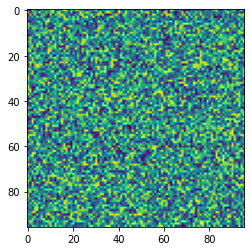

In [6]:
plt.imshow(image)

Okay, we have our image sample. And now let's apply some dummy transformation to it. We are going to rotate the image by `45` degrees. The transformation below takes care of that:

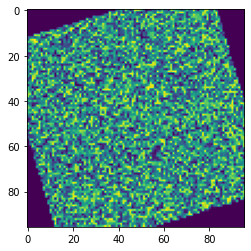

In [7]:
## dummy transformation
dummy_transform = transforms.Compose(
    [transforms.RandomRotation(45)])

dummy_result = dummy_transform(image)

plt.imshow(dummy_result)

Notice you can put the transformations within `transforms.Compose(...)`. You can use the built in transformations offered by PyTorch or you can build your own and compose as you wish. In fact, you can place as many transformation as you wish in there. Let's try another composition of transformations: rotate + vertical flip. 

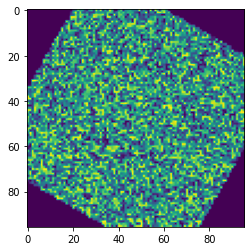

In [8]:
## dummy transform 
dummy2_transform = transforms.Compose(
    [transforms.RandomRotation(45), transforms.RandomVerticalFlip()])

dummy2_result = dummy2_transform(image)

plt.imshow(dummy2_result)

That's pretty cool right! Keep trying other transform methods. On the topic of exploring our data further, let's take a look at our images dataset. 

## Exploring the Data
As a practioner and researcher, I am always spend a bit of time and effort exploring and understanding my datasets. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contain. I will use matplotlib to print out some of the images from our dataset. With a bit of numpy I can convert images into numpy and print them out. Below I print out an entire batch. 

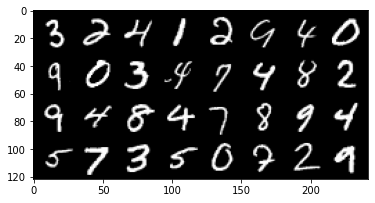

In [9]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

The dimensions of our batches are as follow:

In [10]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## The Model
Now it's time to build the deep learning model that will be used to perform the image classification. We will keeps things simple and stack a few dense layers and a dropout layer to train our model.

Let's discuss a bit about the model:

- First of all the following structure involving a `class` is standard code that's used to build the neural network model in PyTorch:

```python
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # layers go here
    
    def forward(self, x):
        
        # computations go here
```
- The layers are defined inside `def __init__()`. `super(...).__init__()` is just there to stick things together. For our model, we stack a hidden layer (`self.d1`) followed by a dropout layer (`self.dropout`), which is then followed by an output layer (`self.d2`). 
- `nn.Linear(...)` defines the dense layer and it requires the `in` and `out` dimensions, which corresponds to the size of the input feature and output feature of that layer, respectively. 
- `nn.Dropout(...)` is used to define a dropout layer. Dropout is an approach in deep learning that helps a model to avoid overfitting. This means that dropout acts as a regularization technique that helps the model to not overfit on the images it has seen while training. We want this because we need a model that generalizes well to unseen examples -- in our case, the testing dataset. Dropout randomly zeroes some of the units of the neural network layer with probability of `p=0.2`. Read more about the dropout layer [here](https://pytorch.org/docs/stable/nn.html#dropout). 
- The entry point of the model, i.e. where the data enters, is placed under the `forward(...)` function. Typically, we also place other transformations we perform on the data while training inside this function. 
- In the `forward()` function we are performing a series of computations on the input data
    - we flatten the images first, converting it from 2D (`28 X 28`) to 1D (`1 X 784`).
    - then we feed the batches of those 1D images into the first hidden layer
    - the output of that hidden layer is then applied a [non-linear activate function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) called `ReLU`. It's not so important to know what `F.relu()` does at the moment, but the effect that it achieves is that it allows faster and more effective training of neural architectures on large datasets
    - as explained above, the dropout also helps the model to train more efficiently by avoiding overfitting on the training data
    - we then feed the output of that dropout layer into the output layer (`d2`)
    - the result of that is then fed to the [softmax function](https://en.wikipedia.org/wiki/Softmax_function), which converts or normalized the output into a probability distribution which helps with outputting proper predictions values that are used to calculate the accuracy of the model; this will the final output of the model

In [11]:
## the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.d2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

Visually, the following is a diagram of the model we have built. Just keep in mind that the hidden layer is much bigger as shown in the diagram but due to space constraint, the diagram is just an approximation to the actual model. 

![alt text](https://drive.google.com/uc?export=view&id=1NuFflDPOW_hIAHTH2pXZAEhSINygPlnB)

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect. Notice how we are iterating over the dataloader which conveniently stores the `images` and `labels` pairs. `out` contains the output of the model, which are the logits applied a `softmax` layer which helps with prediction. 

In [12]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


We can clearly see that we get back the batches with 10 output values associate with it. These are used to compute the performance of the model. 

## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

- The `learning_rate` is the rate at which the model will try to optimize its weights, which is just another parameter for the model. 
- `num_epochs` is the number of training steps. 
- `device` determines what hardware we will use to train the model. If a `gpu` is present, then that will be used, otherwise it defaults to the `cpu`.
- `model` is just the model instance.
- `model.to(device)` is in charge of setting the actaull device that will be used for training the model
- `criterion` is just the metric that's used to compute the loss of the model while it forward and backward trains to optimize its weights. 
- `optimizer` is the optimization technique used to modify the weights in the backward propagation. Notice that it requires the `learning_rate` and the model parameters which are part of the calculation to optimize weights.


In [13]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The utility function below helps to calculate the accuracy of the model. For now, it's not important to understand how it's calculated but basically it compares the outputs of the model (predictions) with the actual target values (i.e., the labels of the dataset), and tries to compute the average of correct predictions.

In [14]:
## utility function to compute accuracy
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

## Training the Model
Now it's time to train the model. The code portion that follows can be descrive in the following steps:

- The first thing in training a neural network model is defining the training loop, which is achieved by:

```python
for epoch in range(num_epochs):
    ...
```

- We define two variables, `training_running_loss` and `train_acc` that will help us to monitor the running accuracy and loss of the modes while it trains over the different batches.
- `model.train()` explicitly indicates that we are ready to start training. 
- Notice how we are iterating over the dataloader, which conveniently gives us the batches in image-label pairs. 
- That second `for` loop means that for every training step we will iterate over all the batches and train the model over them.
- We feed the model the images via `model(images)` and the output are the predictions of the model. 
- The predictions together with the target labels are used to compute the loss using the loss function we defined earlier.
- Before we update our weights for the next round of training, we perform the following steps:
    - we use the optimizer object to reset all the gradients for the variables it will update. This is a safe step and it doesn't overwrites the gradients the model accumulates while training (those are stored in a buffer [link text](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim) via the `loss.backward() call)
    - `loss.backward()` simply computes the gradient of the loss w.r.t to the model parameters
    - `optimizer.step()` then ensures that the model parameters are updated

- Then we gather and accumulate the loss and accuracy, which is what we will use to tell us if the model is learning properly

In [15]:
## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.5923 | Train Accuracy: 89.19
Epoch: 1 | Loss: 1.5293 | Train Accuracy: 93.95
Epoch: 2 | Loss: 1.5134 | Train Accuracy: 95.35
Epoch: 3 | Loss: 1.5049 | Train Accuracy: 96.10
Epoch: 4 | Loss: 1.5004 | Train Accuracy: 96.47


After all the training steps are over, we can clearly see that the loss keeps decreasing while the training accuracy of the model keeps rising, which is a good sign that the model is effectively learning to classify images.

We can verify that by computing the accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [16]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.11


## Final Words

Congratulation! You have made it to the end of this tutorial. This is a really long tutorial that aims to give an very basic introduction to the fundamentals of image classification using neural networks and PyTorch.

*This tutorial was heavily inspired by this [TensorFlow tutorial.](https://www.tensorflow.org/beta/tutorials/quickstart/beginner) We thank the authors of the corresponding reference for their valuable work.*

## References
- [PyTorch 1.2 Quickstart with Google Colab](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)
- [Get started with TensorFlow 2.0 for beginners](https://www.tensorflow.org/beta/tutorials/quickstart/beginner)
- [PyTorch Data Loading Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
-[ Neural Networks with PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)